In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy.optimize import root_scalar as RS
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

<h1> Class for Black Scholes pricing formula

In [3]:
class BlaSchMet:
    def __init__(self, S, K, T, rf, div_y, option_type):
        self.spot = S
        self.strike = K
        self.total_time = T
        self.risk_free = rf
        self.dividend_yield = div_y
        self.option_type = option_type
        self.volatility = None
        self.find_price = None
        self.option_price = None
        self.d1 = None
        self.d2 = None
        self.x =  None

    
    def set_goal(self, find_price=None, vol=None, find_vol=None, price=None):
        
        if find_price==True:
            self.find_price = True
            self.volatility = vol
        elif find_vol == True:
            self.find_vol = True
            self.option_price = price
        else: 
            print('*State desired goal')
    

    def d1_func(self,post=None):
        part1 = np.log(self.spot/self.strike)
        part2 = (self.risk_free-self.dividend_yield+(1/2)*self.volatility**2)*self.total_time
        part3 = self.volatility*np.sqrt(self.total_time)
        d1 =  (part1+part2) / part3
        self.d1 = d1
        if post == True:
            return self.d1


    def d2_func(self, d1, post=None):
        d2 = d1 - self.volatility*np.sqrt(self.total_time)
        self.d2 = d2
        if post==True:
            return self.d2


    def call_black_scholes(self,x=None, *args):
        if self.x != None:
            self.volatility = x
        part1 = self.spot*np.e**(-self.dividend_yield*self.total_time)*st.norm.cdf(self.d1_func(post=True))
        part2 = self.strike * np.e**(-self.risk_free*self.total_time)*st.norm.cdf(self.d2_func(self.d1,post=True))
        call_price = part1-part2
        disc_strike = self.strike*np.e**(-self.risk_free*self.total_time)
        disc_spot = self.spot*np.e**(-self.dividend_yield*self.total_time)
        if self.option_type=='Call':
            price = call_price
            if self.find_price==True:
                return price
            if self.find_vol==True:
                return price-self.option_price
            
        elif self.option_type=='Put':
            price = call_price+disc_strike-disc_spot
            if self.find_price==True:
                return price
            if self.find_vol==True:
                return price-self.option_price
        else:
            print('*State option_type')


    def find_imp_vol(self, x_guess=None):
        self.x = x_guess
        self.volatility = self.x
        result = RS(self.call_black_scholes, args=(self.option_price,), x0=x_guess, bracket=[0.0001, 2])
        
        return round(result.root,3)
    

    def vega_calc(self):
        part1 = 1/100 *self.spot
        part2 = np.e**(-self.dividend_yield*self.total_time) * np.sqrt(self.total_time)
        part3 = np.e**((-self.d1_func(post=True)**2)/2)/(np.sqrt(2*np.pi))
        result = part1 * part2 *part3
        return result

<h1> Class for Least Squares Monte Carlo 

In [4]:
class LeaSquMonCar():
    def __init__(self, S, K, T, vol, rf,  div_y, option_type, paths, time_steps):
    # def __init__(self, S, K, T, vol, rf,  div_y, option_type, paths, time_steps, df):
        self.spot = S
        self.strike = K
        self.total_time = T
        self.volatility = vol
        self.risk_free =  rf
        self.dividend_yield = div_y
        self.paths = paths
        self.time_steps = time_steps
        self.h =  self.total_time/self.time_steps
        self.option_type = option_type
        # self.pathdf =  df
        self.pathdf = None
        self.payoffdf = None
        self.xes = None
        self.yes = None


    def CreatePaths(self,post=None):
        path_list = []
        for path in range(self.paths):
            path_i = [self.spot]
            for steps in range(self.time_steps):
                part1 = (self.risk_free-self.dividend_yield*(1/2)*self.volatility**2)*self.h
                # np.random.seed(path)
                part2 = np.random.normal(0,1)
                part3 = self.volatility * np.sqrt(self.h)*part2
                S_t = path_i[-1]*np.e**(part1+part3)
                path_i.append(S_t)
            path_list.append(path_i)
        pathsdf = pd.DataFrame(path_list).T
        self.pathdf = pathsdf
        if post == True:
            return  pathsdf
        
    def regress(self, X, Y):
        Xsq = X**2
        df = pd.DataFrame({'id':np.arange(self.paths),
                        'Y':Y,
                        'X':X,
                        'Xsq':Xsq})
        if self.option_type =='Call':
            df=df[df['X']>self.strike]
        elif self.option_type == 'Put':
            df=df[df['X']<self.strike]
        else:  
            None
            
        train = sm.add_constant(df[['X','Xsq']])
        model = sm.OLS(df['Y'],train).fit()
        cond_exp = list(model.params[0]+model.params[1]*train['X']+model.params[2]*train['Xsq'])
        if self.option_type == 'Call':
            boolean = pd.Series([(cond_exp[i]>(X[i]-self.strike)) for i in range(len(train))])
            b = pd.Series(np.where(boolean==True, df['Y'],0), index=df.index)
            b1 = pd.Series(np.where(boolean==False,1,0), index=df.index)
        if self.option_type == 'Put':
            boolean = pd.Series([cond_exp[i]>(self.strike-X[i]) for i in range(len(train))])
            b = pd.Series(np.where(boolean==True, Y,0), index=df.index)        
            b1 = pd.Series(np.where(boolean==False,1,0), index=df.index)
        return [b,b1]
        
    def LeastSquares(self,post=None):
        iddf = self.pathdf.T
        iddf['id'] = np.arange(self.paths)
        Payoff_df = iddf
        disc_r = np.e**((-self.risk_free+self.dividend_yield)*self.h)


        for i in range(0,self.time_steps-1,1):
            data_retY = iddf[self.time_steps-i]
            data_retX = iddf[self.time_steps-(i+1)]
            
            if self.option_type == 'Call':
                if i==0:
                    Y =np.where(data_retY-self.strike>0,data_retY-self.strike,0)*disc_r
                else:
                    Y = Payoff_df[self.time_steps-i]*disc_r
                X = np.where(data_retX-self.strike>0,data_retX,0)
            ################
            if self.option_type == 'Put':
                if i == 0:
                    Y =np.where(self.strike-data_retY>0,self.strike-data_retY,0)*disc_r
                else:
                    Y = Payoff_df[self.time_steps-i]*disc_r
                X = np.where(self.strike-data_retX>0,data_retX,0)
            ################
            cond_exp  = self.regress(X,Y)
            zeros = pd.Series(np.zeros(self.paths))
            zeros.loc[cond_exp[0].index] =  cond_exp[0]/disc_r
            Payoff_df[self.time_steps-i] = np.where(zeros>Y,zeros,0)
            ###################
            zeros = pd.Series(np.zeros(self.paths))
            zeros.loc[cond_exp[1].index] =  cond_exp[1]
            if self.option_type == 'Call':
                rest = np.where(X-self.strike != self.strike, X-self.strike,0)
            else:
                rest = np.where(self.strike-X != self.strike, self.strike-X,0)
            Payoff_df[self.time_steps-(i+1)] = np.where(zeros==1,rest,0)
        ###############################
        for idx in range(Payoff_df.shape[0]):
            row = Payoff_df.iloc[idx,1:]
            reset = 0
            for val in range(1,Payoff_df.shape[1]-1):
                if reset == 0:
                    
                    if row[val] > 0:
                        reset += 1
                else:
                    row[val] = 0
            Payoff_df.iloc[idx,1:] = row
        self.payoffdf = Payoff_df
        if post==True:
            return Payoff_df
    
    def EarlyExerciseCoordinates(self):
        # fig, ax = plt.subplots()
        xes = []
        yes = []
        for i in range(0,len(self.payoffdf),1):
            x = np.where(self.payoffdf.iloc[i,1:-1]>0)
            y = sum(self.payoffdf.iloc[i,1:-1])
            if len(x[0]) != 0:
                # if self.option_type == 'Call':
                    # ax.scatter(x[0][0]+1, self.strike+y, color='red', alpha=.3)
                # else:
                    # ax.scatter(x[0][0]+1, self.strike-y, color='red', alpha=.3)
                # ax.plot(self.pathdf[i],color='grey',alpha=0.3)
                xes.append(x[0][0])
                yes.append(y)
        self.xes = xes
        self.yes = yes
        return [xes,yes]
    
    def OptionPrice(self):
        # n_exercises = len(self.paths)
        total_npv = []
        for i in range(1,len(self.xes),1):
            pv_sel = self.yes[i]*(np.e**(-(self.risk_free-self.dividend_yield)))**(self.xes[i]+1)
            total_npv.append(pv_sel)
        value = sum(total_npv)/self.paths
        return value
        # print('Call value using LSMC:', round(value,4))
        

<h1> Class for Binomial Option Pricing Model

In [5]:
class BinPriMod:
    def __init__(self, S:float, K:float, sigma:float, total_time:float, period_timespan:float, rate_i:float,
                 option_type:str, exercise_style:str):
        self.spot = S
        self.strike = K
        self.risk = sigma
        self.total_time = total_time
        self.period_time_span = period_timespan
        self.risk_free = rate_i
        self.option_type = option_type
        self.exercise_style = exercise_style
        self.n_periods = int(self.total_time / self.period_time_span)
        self.dividend_yield = None
        self.time_single_div = None
        self.amount_single_div = None
        self.values = None
        self.prices = None
        self.forwards = None


    def help():
        print('def __init__(self, S, K, sigma, T, h, rate_i, option_type, exercise_style):')
        print('\n')
        print('Attributes:\n    up_and_down,\n  storage_values,\n   option_price')

    
    def set_dividends(self, cont=None, cont_rate=None, TD=None, amount=None):
        if cont == True:
            self.dividend_yield = cont_rate
        else:
            self.dividend_yield = cont_rate
            self.time_single_div = TD
            self.amount_single_div = amount

    def up_and_down(self, spot, t):   
        u = np.e**((self.risk_free - self.dividend_yield) * 
                                self.period_time_span) * np.e**(self.risk*np.sqrt(self.period_time_span))
        d = np.e**((self.risk_free -self.dividend_yield) * 
                                self.period_time_span) *np.e**(-self.risk*np.sqrt(self.period_time_span))
        if self.amount_single_div == None:
            uS = spot*u
            dS = spot*d
            return [uS,dS]
        else: 
            pFp = spot - self.amount_single_div*np.e**(-self.risk_free*(self.time_single_div-t))
            div_multiplier = np.e**(-self.risk_free*(self.time_single_div-(t+self.period_time_span)))
            uS = pFp*u + self.amount_single_div*div_multiplier
            dS = pFp*d + self.amount_single_div*div_multiplier
            if self.time_single_div >= t and self.time_single_div <t+self.period_time_span:
                uS = (spot-self.amount_single_div)*u
                dS = (spot-self.amount_single_div)*d
            return [uS, dS]


    def storage_values(self, post=None):
        storage = [[self.spot]]
        for i in range(0, self.n_periods,1):
            sub_storage = []
            for j in range(0, len(storage[i]),2):   
                sub_storage.append(np.array(self.up_and_down(storage[i][j],(i)*self.period_time_span)))
            if (i+1)>=2:
                if (i+1)%2== 0:
                    sub_storage.append(np.reshape(self.up_and_down(storage[i][j+1], (i)*self.period_time_span)[1],(1,)))                                            
            fixed = np.concatenate(sub_storage)
            storage.append(np.round(fixed,3))
        self.values = storage
        if post == True:
            return self.values 

    
    def PrepaidForwad(self, post=None):
        prepfor = []
        for i in range(len(self.values)-1):
            sel_prepfor = []
            for j in range(len(self.values[i])):
                part0 = -self.risk_free*(self.time_single_div-self.period_time_span*i)

                part1 = self.values[i][j] - self.amount_single_div*np.e**(part0)
                # part0 = -self.risk_free*(self.time_single_div-self.period_time_span*i)
                sel_prepfor.append(round(part1,3))
            prepfor.append(sel_prepfor)
        prepfor.append(self.values[-1])
        self.forwards = prepfor
        if post==True:
            return prepfor


    def option_price(self, 
                     up, down, alt_spot, org_spot,
                     high_optpri, low_optpri):
        u = up/alt_spot
        d = down/alt_spot
        p_part1 = (self.risk_free-self.dividend_yield)*self.period_time_span
        p = (np.e**(p_part1)-d) / (u-d)
        disc = np.e**(-self.risk_free*self.period_time_span)
        def price(p,ou,od,disc):
            return (p*ou + (1-p)*od) * disc

        opt_price = price(p,high_optpri,low_optpri,disc)

        if self.exercise_style == 'European':
            opt_price = opt_price
        elif self.exercise_style == 'American':
            if self.option_type =='Put':
                opt_price = max(opt_price, self.strike - org_spot)
            else:
                opt_price = max(opt_price, org_spot - self.strike)            
        else:
            print('State exercise style!!!')
        return round(opt_price,3)
    

    def storage_prices(self, post=None):
        latest_opt_pri = []
        if self.option_type=='Call':
            array = np.where(self.values[self.n_periods]-self.strike>0,self.values[self.n_periods]-self.strike,0)
        elif self.option_type=='Put':
            array = np.where(self.values[self.n_periods]-self.strike<0,self.values[self.n_periods]-self.strike,0)
        else:
            print('State option type!!!')
        latest_opt_pri.append(abs(array))

        for i in range(0, self.n_periods, 1): 
            sub_optpri_storage = []
            for j in range(0,self.n_periods-i,1):   #periods- 1
                if self.forwards != None:
                    relevant = self.forwards
                else: 
                    relevant = self.values
                
                u = relevant[self.n_periods-i][j]
                d = relevant[self.n_periods-i][j+1]
                alt_spot =  relevant[self.n_periods-(i+1)][j]

                org_spot = self.values[self.n_periods-(i+1)][j]
                sub_optpri_storage.append(self.option_price(u, d, alt_spot, org_spot,
                                                            latest_opt_pri[i][j], 
                                                            latest_opt_pri[i][j+1]))
            latest_opt_pri.append(np.round(sub_optpri_storage,2))
        self.prices = latest_opt_pri
        if post == True:
            return self.prices
        return self.prices
         

    def plot_tree(self,txt_shift):
        fig, ax = plt.subplots(figsize=(6,6))
        for i in range(0,int(self.n_periods)+1,1):
            ax.scatter(x=np.repeat((i)*1,i+1), y= self.values[i])
            for j in range(0,i+1,1):
                text_value = 'Value '+ str(self.values[i][j])
                text_price = 'Price '+ str(self.prices[self.n_periods-i][j])
                ax.annotate(text_value, xy=(i*1, self.values[i][j]+txt_shift))
                ax.annotate(text_price, xy=(i*1, self.values[i][j]-txt_shift))
                if self.forwards != None:
                    text_forward = 'PreF. '+ str(self.forwards[i][j])
                    ax.annotate(text_forward, xy=(i*1, self.values[i][j]))

            ax.set_xlabel('Periods')
        ax.set_ylabel('Price')
        plt.xlim(-1,self.n_periods+2*self.period_time_span)
        plt.title('Binomial tree for '+self.exercise_style+' '+self.option_type+' option')
        plt.show()

<h1> Task  1 </h1>
<h2> 1.1 Find implied volatility

In [6]:
ex1a = BlaSchMet(200,210, 3, 0.05,0.01,'Put')
ex1a.set_goal(find_price=False,vol=0,find_vol=True,price=9.74)
impvol = ex1a.find_imp_vol(x_guess=0.0001)
print('Implied volatility:', round(impvol,20))

Implied volatility: 0.12


<h2> 1.2 Find vega</h2> 

In [7]:
ex1b = BlaSchMet(200,210,3,0.05,0.01, 'Put')
ex1b.set_goal(find_price=True, vol=0.12, find_vol=False, price=None)
# ex1b.call_black_scholes()
vega = ex1b.vega_calc()
print('Vega:', round(vega,2))

Vega: 1.21


<h2> 1.3 Iterate thorugh implied volatilities</h2>

In [8]:
df = pd.read_csv('data_ex1.csv')
del df['Unnamed: 2']
df.head(2)

,Strike,Last Price
0,100.0,0.01
1,105.0,0.01


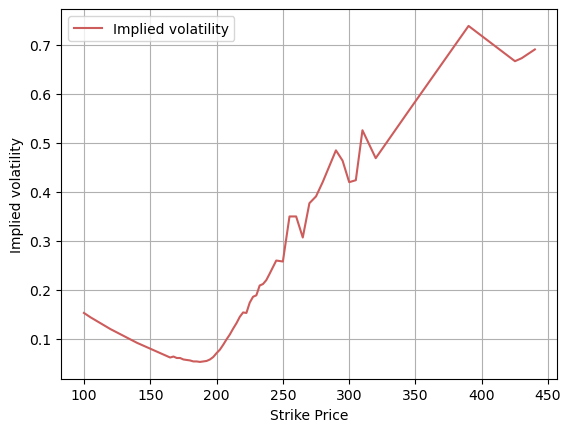

In [9]:
vol_list = []
for i in range(len(df)):
    ex1c = BlaSchMet(200,df['Strike'][i],3,0.05,0.01, 'Put')
    ex1c.set_goal(find_price=False, vol=None, find_vol=True, price=df['Last Price'][i])
    # ex1c.set_goal(find_price=False, vol=None, find_vol=True, price=9)
    vol = ex1c.find_imp_vol(x_guess=0.0001)
    vol_list.append(vol)


fig, ax = plt.subplots()
ax.plot(df['Strike'],vol_list, 
        label='Implied volatility',
        color='indianred')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Implied volatility')
plt.grid()
plt.legend()
plt.show()

<h2> 1.4 Iterate thorugh vegas</h2>

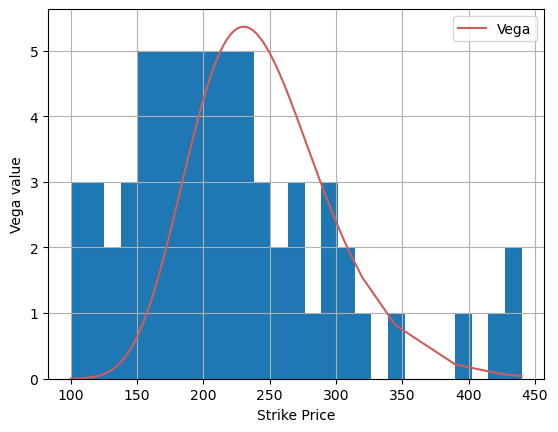

In [10]:
vega_list = []
for i in range(len(df)):
    ex1d = BlaSchMet(200,df['Strike'][i],3,0.05,0.01, 'Put')
    ex1d.set_goal(find_price=True, vol=0.12, find_vol=False, price=0)
    vega = ex1d.vega_calc()
    vega_list.append(vega)

fig, ax = plt.subplots()
ax.plot(df['Strike'],np.array(vega_list)*4, 
        label='Vega', color='indianred')
ax.set_xlabel('Strike Price')
ax.set_ylabel('Vega value')
plt.hist(df['Strike'],bins=27)
plt.grid()
plt.legend()
plt.show()
# plt.savefig('1d.PNG')

<h2> Additional code for task 1

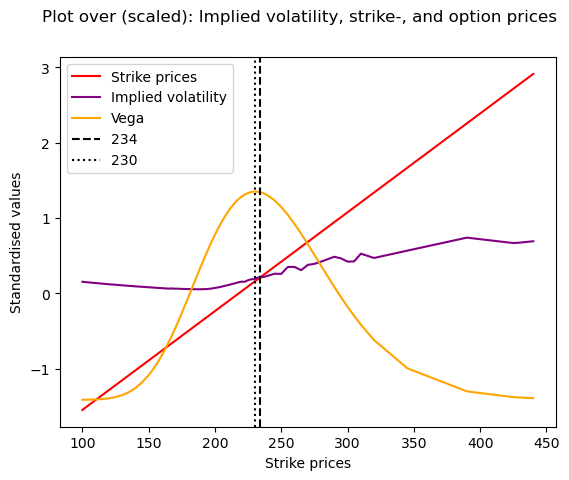

In [11]:
def scale(X):
    X = np.array(X)
    scaled = (X-X.mean())/X.std()
    return scaled

fig, ax = plt.subplots()
ax.plot(df['Strike'], scale(df['Strike']), label='Strike prices',color='r')
ax.plot(df['Strike'], vol_list, label='Implied volatility', color='purple')
ax.plot(df['Strike'], scale(vega_list), label='Vega', color='orange')
ax.axvline(234,color='black', linestyle='dashed', label='234')
ax.axvline(df['Strike'][42], color='black', linestyle='dotted',label=str(230))
ax.set_xlabel('Strike prices')
ax.set_ylabel('Standardised values')
fig.suptitle('Plot over (scaled): Implied volatility, strike-, and option prices')
plt.legend()
plt.show()

<h1> Task 2 </h1>
<h2> Task 2a </h2>

In [12]:
#BOPM call
ex2ai1 = BinPriMod(200,210,0.2,3,0.3,0.05,'Call','American',)
ex2ai1.set_dividends(cont=True, cont_rate=0.01, TD=None, amount=None)
ex2ai1.storage_values(False)
# ex2ai1.storage_prices()[-1][0]
A_ex2ai1 = ex2ai1.storage_prices(True)[-1][0]
#BOPM put
ex2ai2 = BinPriMod(200, 210, 0.2,3,0.3,0.05,'Put','American',)
ex2ai2.set_dividends(cont=True, cont_rate=0.01, TD=None, amount=None)
ex2ai2.storage_values(False)
A_ex2ai2 = ex2ai2.storage_prices(True)[-1][0]
#BSM call
ex2aii1 = BlaSchMet(200,210,3,0.05,0.01,'Call')
ex2aii1.set_goal(find_price=True,vol=0.2,find_vol=False,price=None)
A_ex2aii1 = ex2aii1 .call_black_scholes()
#BSM put
ex2aii1 = BlaSchMet(200,210,3,0.05,0.01,'Put')
ex2aii1.set_goal(find_price=True,vol=0.2,find_vol=False,price=None)
A_ex2aii2 = ex2aii1.call_black_scholes()
pd.DataFrame({'BSM':[A_ex2aii1,A_ex2aii2],
              'BOPM':[A_ex2ai1, A_ex2ai2]}, index=['Call','Put'])

,BSM,BOPM
Call,32.979069,33.43
Put,19.638638,23.53


<h2> Task 2b </h2>

In [13]:
val_list = []
for i in range(0,100,1):
    ex2bCall  = LeaSquMonCar(200,210,3,0.2,0.05,0.01,'Call',100,10)
    ex2bCall.CreatePaths(post=False)
    ex2bCall.LeastSquares()
    ex2bCall.EarlyExerciseCoordinates()
    val = ex2bCall.OptionPrice()
    val_list.append(val)
print('Call value using LSMC:', round(np.mean(val),4))

Call value using LSMC: 22.7385


In [14]:
val_list = []
for i in range(0,100,1):
    ex2bPut  = LeaSquMonCar(200,210,3,0.2,0.05,0.01,'Put',100,10)
    ex2bPut.CreatePaths(post=False)
    ex2bPut.LeastSquares()
    ex2bPut.EarlyExerciseCoordinates()
    val = ex2bPut.OptionPrice()
    val_list.append(val)
print('Put value using LSMC:', round(val,4))

Put value using LSMC: 14.6382


<h2> Task 2c

In [15]:
ex2c = LeaSquMonCar(200, 210, 3, 0.2, 0.05, 0.01, 'Call', 10000,100)
ex2c.CreatePaths(post=False) 
ex2c.LeastSquares(post=False)
coords = ex2c.EarlyExerciseCoordinates()
val = ex2c.OptionPrice()

In [16]:
print('Call value using LSMC:', round(val,4))
ratio =len(np.where(np.array(coords[0])<660)[0])/10000
print('N_early_exercise / n_paths:', round(ratio,3))

Call value using LSMC: 5.757
N_early_exercise / n_paths: 0.84


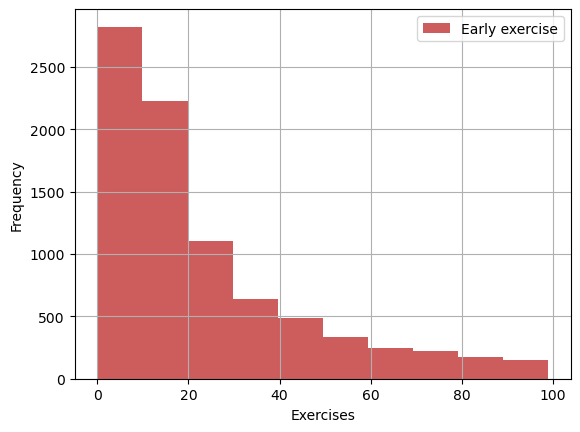

In [17]:
plt.figure()
plt.hist(coords[0], color='indianred',label='Early exercise' )
plt.xlabel('Exercises')
plt.ylabel('Frequency')
plt.grid()
plt.legend()
plt.show()

<h2> Task 2d

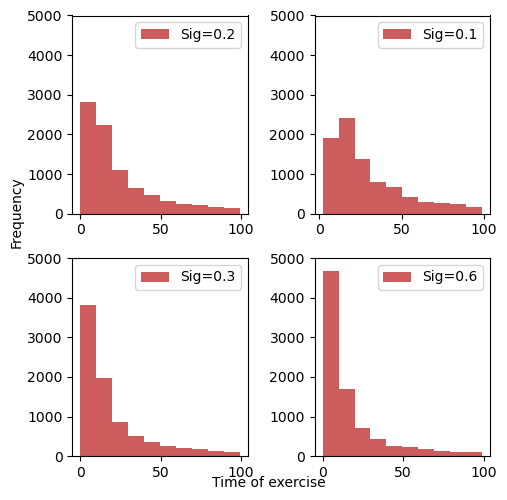

In [18]:
ex2di = LeaSquMonCar(200, 210, 3, 0.1, 0.05, 0.01, 'Call', 10000, 100)
ex2di.CreatePaths(post=False) 
ex2di.LeastSquares(post=False)
coordsA = ex2di.EarlyExerciseCoordinates()

ex2dii = LeaSquMonCar(200, 210, 3, 0.3, 0.05, 0.01, 'Call', 10000, 100)
ex2dii.CreatePaths(post=False) 
ex2dii.LeastSquares(post=False)
coordsB = ex2dii.EarlyExerciseCoordinates()

ex2diii = LeaSquMonCar(200, 210, 3, 0.6, 0.05, 0.01, 'Call', 10000, 100)
ex2diii.CreatePaths(post=False) 
ex2diii.LeastSquares(post=False)
coordsC = ex2diii.EarlyExerciseCoordinates()


axes = [(0,0),(0,1),(1,0),(1,1)]
heights = [coords,coordsA,coordsB,coordsC]
sigs = [0.2,0.1,0.3,0.6]
fig, ax = plt.subplots(2,2, figsize=(5,5))
for i in range(0,4,1):
    ax[axes[i]].hist(heights[i][0], color='indianred', label='Sig='+str(sigs[i]))
    ax[axes[i]].set_ylim(0,5000)
    ax[axes[i]].legend()
fig.text(0.01, 0.5, 'Frequency', ha='center', rotation='vertical')
fig.text(0.4, 0.01, 'Time of exercise', va='bottom')
fig.tight_layout()
plt.show()

<h2> Additional code for task 2

In [19]:
kurt_list = []
skew_list = []
for i in range(10,60,1):
    ex2d = LeaSquMonCar(200, 210, 3, i/100, 0.05, 0.01, 'Call', 1000, 100)
    ex2d.CreatePaths(post=True) 
    ex2d.LeastSquares()
    coords = ex2d.EarlyExerciseCoordinates()[0]
    kurt_list.append(st.kurtosis(coords))
    skew_list.append(st.skew(coords))

plt.figure()
plt.plot(np.linspace(10,60),skew_list,color='indianred', label='Skewness')
plt.plot(np.linspace(10,60), kurt_list, color='green', label='Kurtosis')
plt.xlabel('Volatility /100')
plt.ylabel('Values for kurtosis and skewness')
plt.legend()
plt.show()

<h1> Task 3b

In [ ]:
# S, K, vol, T, h, rf, option type, exercise style
myTree = BinPriMod(100, 95, 0.25, 1, 1/11, 0.05, 'Call', 'American')
# boolean, cont_div_y, time single div, amount single div
myTree.set_dividends(cont=False, cont_rate=0, TD=2/12, amount=10)
myTree.storage_values(False)
myTree.PrepaidForwad(False)
myTree.storage_prices(False)
myTree.plot_tree(2)

In [ ]:
print('Option value:', myTree.storage_prices()[-1][0])

In [ ]:
# S, K, vol, T, h, rf, option type, exercise style
myTree = BinPriMod(100, 95, 0.25, 1, 1/11, 0.05, 'Call', 'American')
# boolean, cont_div_y, time single div, amount single div
myTree.set_dividends(cont=False, cont_rate=0, TD=4/12, amount=10)
myTree.storage_values(False)
myTree.PrepaidForwad(False)
myTree.storage_prices(False)
myTree.storage_prices()[-1]

In [ ]:
# S, K, vol, T, h, rf, option type, exercise style
myTree = BinPriMod(100, 95, 0.25, 1, 1/11, 0.05, 'Call', 'American')
# boolean, cont_div_y, time single div, amount single div
myTree.set_dividends(cont=False, cont_rate=0, TD=7/12, amount=10)
myTree.storage_values(False)
myTree.PrepaidForwad(False)
myTree.storage_prices(False)
myTree.storage_prices()[-1]

In [ ]:
price_list = []
for i in range(1,121,1):
    itTree = BinPriMod(100, 95, 0.25, 1, 1/11, 0.05, 'Call', 'American')
    itTree.set_dividends(cont=False, cont_rate=0, TD=i/120, amount=10)
    itTree.storage_values(False)
    itTree.PrepaidForwad(False)
    itTree.storage_prices(False)
    price_list.append(itTree.storage_prices()[-1])


plt.plot(price_list, color='indianred', label='Option Price')
plt.xlabel('Dividend payout time in years (x/100)')
plt.ylabel('Option prices')
plt.legend()
plt.show()